## Accessing Cloud Optimized Data

Authors: Samuel Ayers (UAH)

Date: April 28, 2021 (Revised July 2023)

Description: The following is an example that uses Shuttle Radar Topography Mission (SRTM) Cloud Optimized GeoTIFF (COG) data from the MAAP data store, via MAAP STAC search. In this example, we read in elevation data using a bounding box tile.

## Run This Notebook

To access and run this tutorial within MAAP's Algorithm Development Environment (ADE), please refer to the "Getting started with the MAAP" section of our documentation. 

Disclaimer: it is highly recommended to run a tutorial within MAAP's ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors.

## Additional Resources

- [Using pystac-client](https://pystac-client.readthedocs.io/en/stable/api.html)


## Importing and Installing Packages

To be able to run this notebook you'll need the following requirements:

- rasterio
- folium
- geopandas
- rio-cogeo


If the packages below are not installed already, uncomment the following cell

In [1]:
# %pip install -U folium geopandas rasterio>=1.2.3 rio-cogeo
# %pip install pystac-client

In [2]:
# import the maap package to handle queries
from maap.maap import MAAP

# invoke the MAAP
maap = MAAP()

We can use pystac_client `get_collection` to retrieve the desired collection, in this case the SRTMGL1_COD collection and set the result of the function to a variable.

In [3]:
# Get the SRTMGL1_COD collection
from pystac_client import Client
catalog = 'https://stac.maap-project.org/'
client = Client.open(catalog)

collection = client.get_collection('SRTMGL1_COD')
collection

<CollectionClient id=SRTMGL1_COD>

We can narrow the area of interest for the items within the collection by passing bounding box values into the pystac_client `search` function.

In [4]:
# set bounding box
bbox = "-101.5,45.5,-100.5,46.5"

# retreive STAC items from the collection that are within the bounding box
search = client.search(bbox=bbox, collections=collection, max_items=20)

Let's check how many items we are working with.

In [5]:
# show number of items in search results
len(list(search.items()))

4

### Inspecting the Results
Now we can work on inspecting our results. In order to do this, we import the `geopandas`,`shapely`, and `folium` packages.

In [6]:
# import geopandas to work with geospatial data
import geopandas as gpd

# import shapely for manipulation and analysis of geometric objects
from shapely.geometry import shape, box

# import folium to visualize data in an interactive leaflet map
import folium

We can use the `gpd.GeoSeries` function to create a GeoSeries of all the shapely polygons created from the geometries of our item results. According to the [GeoPandas documentation](https://geopandas.org/docs/reference/geoseries.html), a GeoSeries is a "Series [a type of one-dimensional array] object designed to store shapely geometry objects". We use 'EPSG:4326' (WGS 84) for the coordinate reference system then we can check the GeoSeries.

In [7]:
# create GeoSeries of all polygons from granule results with WGS 84 coordinate reference system
geometries = gpd.GeoSeries(
    [shape(item.geometry) for item in search.items()],
    crs='EPSG:4326'
)

# check GeoSeries
geometries

0    POLYGON ((-102.00014 45.99986, -100.99986 45.9...
1    POLYGON ((-101.00014 45.99986, -99.99986 45.99...
2    POLYGON ((-102.00014 44.99986, -100.99986 44.9...
3    POLYGON ((-101.00014 44.99986, -99.99986 44.99...
dtype: geometry

Now we create a list from our bounding box values. Then we use the `centroid` function to get the centroid of our bounding box and set to a point. Next we use `folium.Map` to create a map. For the map's parameters, let's set the centroid point coordinates as the location, "cartodbpositron" for the map tileset, and 7 as the starting zoom level. With our map created, we can create a dictionary containing style information for our bounding box. Then we can use `folium.GeoJson` to create GeoJsons from our `geometries` GeoSeries and add them to the map. We also use the `folium.GeoJson` function to create a GeoJson of a polygon created from our bounding box list, name it, and add our style information. Finally, we check the map by displaying it.

In [8]:
# create list of bounding box values
bbox_list =  [float(value) for value in bbox.split(',')]

# get centroid point from bounding box values
center = box(*bbox_list).centroid

# create map with folium with arguments for lat/lon of map, map tileset, and starting zoom level
m = folium.Map(
    location=[center.y,center.x],
    tiles="cartodbpositron",
    zoom_start=7,
)
# create style information for bounding box
bbox_style = {'fillColor': '#ff0000', 'color': '#ff0000'}

# create GeoJson of `geometries` and add to map
folium.GeoJson(geometries, name="tiles").add_to(m)

# create GeoJson of `bbox_list` polygon and add to map with specified style
folium.GeoJson(
    box(*bbox_list), 
    name="bbox",
    style_function=lambda x:bbox_style
).add_to(m)

# display map
m

### Creating a Mosaic
Let's check the raster information contained in our item results. In order to do this, we import some more packages. 
- To read and write files in raster format, import `rasterio`. 
    - From `rasterio` we import `merge` to copy valid pixels from an input into an output file
    - `AWSSession` to set up an Amazon Web Services (AWS) session
    - `show` to display images and label axes
- Import `boto3` in order to work with AWS
- From `matplotlib`, we want to import `imshow` which allows us to display images from data - Import `numpy` to work with multi-dimensional arrays and `numpy.ma` to work with masked arrays. 
- From `pyproj`, import `Proj` for converting between geographic and projected coordinate reference systems and `Transformer` to make transformations.

In [9]:
# import rasterio for reading and writing in raster format
import rasterio as rio

# copy valid pixels from input files to an output file.
from rasterio.merge import merge

# set up AWS session
from rasterio.session import AWSSession 

# display images, label axes
from rasterio.plot import show

# import boto3 to work with Amazon Web Services
import boto3

# display images from data
from matplotlib.pyplot import imshow

# import numpy to work with multi-dimensional arrays
import numpy as np

# import numpy.ma to work with masked arrays
import numpy.ma as ma

# convert between geographic and projected coordinates and make transformations
from pyproj import Proj, Transformer

Finally, we import `os` and run some code in order to speed up Geospatial Data Abstraction Library (GDAL) reads from Amazon Simple Storage Service (S3) buckets by skipping sidecar (connected) files.

In [10]:
# speed up GDAL reads from S3 buckets by skipping sidecar files
import os
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'

Now that we have the necessary packages, let's get a list of S3 urls to the granules. To start, set up an AWS session. The S3 urls are contained within the `search.items()` assets, so we loop through the items in our results to get the S3 urls and add them to a new list. We can then use the `sort` function to sort the S3 urls in an acending order. Then we can check our S3 url list.

In [11]:
# set up AWS session
aws_session = AWSSession(boto3.Session())

# get the S3 urls to the granules
file_S3 = [item.assets["cog_default"].href for item in search.items()]

# sort list in ascending order
file_S3.sort()

# check list
file_S3

['s3://nasa-maap-data-store/file-staging/nasa-map/SRTMGL1_COD___001/N45W101.SRTMGL1.tif',
 's3://nasa-maap-data-store/file-staging/nasa-map/SRTMGL1_COD___001/N45W102.SRTMGL1.tif',
 's3://nasa-maap-data-store/file-staging/nasa-map/SRTMGL1_COD___001/N46W101.SRTMGL1.tif',
 's3://nasa-maap-data-store/file-staging/nasa-map/SRTMGL1_COD___001/N46W102.SRTMGL1.tif']

We can now check to see that we can read the AWS files and display a thumbnail. Pass the boto3 session to `rio.Env`, which is the GDAL/AWS environment for `rasterio`. Use the `rio.open` function to read in one of the Cloud Optimized GeoTIFFs. 

Now let's use the `overviews` command to get a list of overviews. Overviews are versions of the data with lower resolution, and can thus increase performance in applications. Let's get the first overview from our list for retrieving a thumbnail. 

Retrieve a thumbnail by reading the first band of our file and setting the shape of the new output array. The shape can be set with a tuple of integers containing the number of datasets as well as the `height` and `width` of the file divided by our integer from the overview list. Now use the `show` function to display the thumbnail.

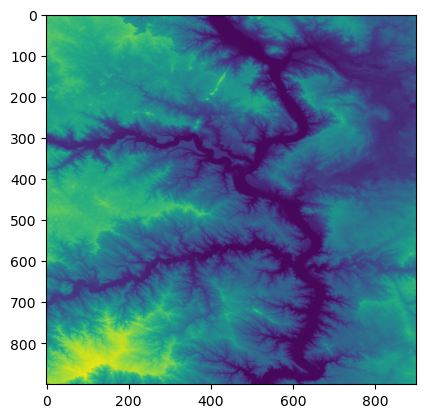

<Axes: >

In [12]:
# prove that we can read the AWS files
# for more information - https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html
with rio.Env(aws_session):
    with rio.open(file_S3[0], 'r') as src:
        # list of overviews
        oviews = src.overviews(1)
        # get second item from list to retrieve a thumbnail
        oview = oviews[1]
        # read first band of file and set shape of new output array
        thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
# now display the thumbnail
show(thumbnail)


Since we verified that we can read the AWS files and display a thumbnail, we can create a mosaic from all of the rasters in our `file_S3` list. To do this, again pass the boto3 session to `rio.Env`. Then create a list which contains all of the read in Cloud Optimized GeoTIFFs (this may take a while).

In [13]:
# create a mosaic from all the images
with rio.Env(aws_session):
    sources = [rio.open(raster) for raster in file_S3]

Now we can use the `merge` function to merge these source files together using our list of bounding box values as the bounds. `merge` copies the valid pixels from input rasters and outputs them to a new raster.

In [14]:
# merge the source files
mosaic, out_trans = merge(sources, bounds = bbox_list)

Lastly, we use ma.masked_values for masking all of the NoData values, allowing the mosaic to be plotted correctly. ma.masked_values returns a MaskedArray in which a data array is masked by an approximate value. For the parameters, let's use our mosaic as the data array and the integer of the "nodata" value as the value to mask by. Now we can use `show` to display our masked raster using `matplotlib` with a "terrain" colormap.

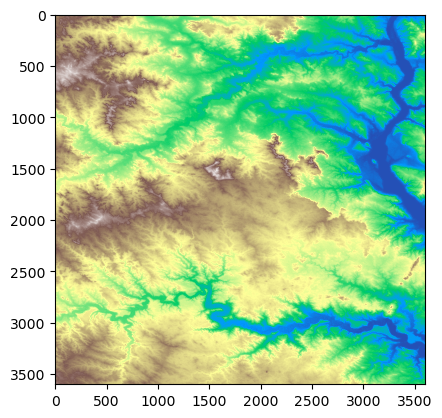

<Axes: >

In [15]:
# mask the NoData values so it can be plotted correctly
masked_mosaic = ma.masked_values(mosaic, int(sources[0].nodatavals[0]))

# display the masked mosaic
show(masked_mosaic, cmap = 'terrain')